# Imports

`numpy`      package for array handling  
`pandas`     import to create and modify dataframes     
`matplotlib` package for data visulization  
`seaborn`    build on matploblib, higher level graph functions

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the data
Here we are taking the inbuilt function of keras to load the data from the server  
The dataset file in present in the [Link to dataset in amazon server](https://s3.amazonaws.com/text-datasets/imdb.npz)  
The inbuilt code 
```python
def load_data(path='imdb.npz', num_words=None, skip_top=0,
              maxlen=None, seed=113,
              start_char=1, oov_char=2, index_from=3, **kwargs):
    """Loads the IMDB dataset.
    # Arguments
        path: where to cache the data (relative to `~/.keras/dataset`).
        num_words: max number of words to include. Words are ranked
            by how often they occur (in the training set) and only
            the most frequent words are kept
        skip_top: skip the top N most frequently occurring words
            (which may not be informative).
        maxlen: sequences longer than this will be filtered out.
        seed: random seed for sample shuffling.
        start_char: The start of a sequence will be marked with this character.
            Set to 1 because 0 is usually the padding character.
        oov_char: words that were cut out because of the `num_words`
            or `skip_top` limit will be replaced with this character.
        index_from: index actual words with this index and higher.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    # Raises
        ValueError: in case `maxlen` is so low
            that no input sequence could be kept.
    Note that the 'out of vocabulary' character is only used for
    words that were present in the training set but are not included
    because they're not making the `num_words` cut here.
    Words that were not seen in the training set but are in the test set
    have simply been skipped.
    """
    # Legacy support
    if 'nb_words' in kwargs:
        warnings.warn('The `nb_words` argument in `load_data` '
                      'has been renamed `num_words`.')
        num_words = kwargs.pop('nb_words')
    if kwargs:
        raise TypeError('Unrecognized keyword arguments: ' + str(kwargs))

    path = get_file(path,
                    origin='https://s3.amazonaws.com/text-datasets/imdb.npz',
                    file_hash='599dadb1135973df5b59232a0e9a887c')
    with np.load(path) as f:
        x_train, labels_train = f['x_train'], f['y_train']
        x_test, labels_test = f['x_test'], f['y_test']

    np.random.seed(seed)
    indices = np.arange(len(x_train))
    np.random.shuffle(indices)
    x_train = x_train[indices]
    labels_train = labels_train[indices]

    indices = np.arange(len(x_test))
    np.random.shuffle(indices)
    x_test = x_test[indices]
    labels_test = labels_test[indices]

    xs = np.concatenate([x_train, x_test])
    labels = np.concatenate([labels_train, labels_test])

    if start_char is not None:
        xs = [[start_char] + [w + index_from for w in x] for x in xs]
    elif index_from:
        xs = [[w + index_from for w in x] for x in xs]

    if maxlen:
        xs, labels = _remove_long_seq(maxlen, xs, labels)
        if not xs:
            raise ValueError('After filtering for sequences shorter than maxlen=' +
                             str(maxlen) + ', no sequence was kept. '
                             'Increase maxlen.')
    if not num_words:
        num_words = max([max(x) for x in xs])

    # by convention, use 2 as OOV word
    # reserve 'index_from' (=3 by default) characters:
    # 0 (padding), 1 (start), 2 (OOV)
    if oov_char is not None:
        xs = [[w if (skip_top <= w < num_words) else oov_char for w in x]
              for x in xs]
    else:
        xs = [[w for w in x if skip_top <= w < num_words]
              for x in xs]

    idx = len(x_train)
    x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
    x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])

    return (x_train, y_train), (x_test, y_test)


def get_word_index(path='imdb_word_index.json'):
    """Retrieves the dictionary mapping words to word indices.
    # Arguments
        path: where to cache the data (relative to `~/.keras/dataset`).
    # Returns
        The word index dictionary.
    """
    path = get_file(
        path,
        origin='https://s3.amazonaws.com/text-datasets/imdb_word_index.json',
        file_hash='bfafd718b763782e994055a2d397834f')
    with open(path) as f:
        return json.load(f)
```
## Regarding Dataset  
Dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".     
As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.   
[official Link](http://ai.stanford.edu/~amaas/data/sentiment/)   


In [2]:
# Loading the dataset
from keras.datasets import imdb
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000,skip_top=0,maxlen=None,seed=113,start_char=1,oov_char=2,index_from=3)

Using TensorFlow backend.


# Understand the dataset
Let see the size and shape of test and training tuples

``On Execution``  
There will be 25000 samples list of different sized word embeddings in training set  
There will be 25000 samples list of different sized word embeddings in testing set
The first review would be (218,) sized word embedding

In [3]:
#Understanding the data
print("The number of training samples",len(x_train))
print("The number of testing samples",len(x_test))
print("The shape of training samples array",np.shape(x_train))
print("The shape of training samples labels", np.shape(y_train))
print("First element in x_train ,its type :",type(x_train[0]),"it's shape :",np.shape(x_train[0]))

The number of training samples 25000
The number of testing samples 25000
The shape of training samples array (25000,)
The shape of training samples labels (25000,)
First element in x_train ,its type : <class 'list'> it's shape : (218,)


# Visualizing the data
Let us try to visualise the few samples of data so, we could get an idea of how the data looks like  
`On Execution`  
We can see first two reviews
> Note: on loading the dataset we load the word embedding, to convert into the actual reviews we take the help of word to index dictonary to convert the given words embedding to actual reviews.

In [4]:
# Data Visulization

# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()]) # Reversed dictionary

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

## Viewing the review's
print('\nFirst Review \n')
print(decode_review(x_train[0]))
print('\nIts label :',y_train[0])

print('\nSecond Review \n')
print(decode_review(x_train[1]))
print('\nIts label :',y_train[1])


First Review 

the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but and to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other and in of seen over landed for anyone of and br show's to whether from than out themselves history he name half some br of and odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when from one 

# Preprocessing the data

## Padding
Each review in the dataset would have a different size but, in a neural network model would like to have all its inputs of same size for that we all padding to the reviews.  
We make sure all the embeddings have the same length of max lenght i.e. 256 (for this dataset).   
For embeddings longer than 256 the enddings will be chopped off.   
For embeddings shorter than 256 '0' (zeros) would be 
> Note: On adding 0 to the embeddings we are not creating a new word in the embedding. The dataset doesn't assign any word to the value 0 . 0 is some kind of unknown word which we use as padding.

In [5]:
# Data Preprocessing
## Padding
from keras.preprocessing.sequence import pad_sequences
x_train_padded = pad_sequences(x_train,value=0,padding='post',maxlen=256)
x_test_padded =  pad_sequences(x_test,value=0,padding='post',maxlen=256)

# Training varibles
These Training varbles are hyper parameters for neural network training.   
`epochs` : each epoch is forward propagation + backward propagation over the whole dataset once is called one epoch.  
`learning_rate` : the magnitude in which the weights are modified one the acquired loss.   
`learning_rate_decay` : there can be high leanring rate at the beining of the training when the loss is high. Over a period of time the learning rate can reduce for fine training of network.  
`batch_size` : the data is fed to the network in batches of 32 samples at each time. This batch feeding is done all over the whole dataset.  

`vocab_size` : vocab size is the total number of words present in the dictonary. This size would represent the input size to the nural network model

In [6]:
# Training varibles
learning_rate = 0.00001
learning_rate_decay = 0.00001
batch_size = 512
epochs = 60
classes = 2
## input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

# Neural Netowork Model
`Line 6` : we are building a keras sequential model  
`Line 13` : we are using Adam optimizer  
`Line 16` : compiling the model to check if the model is build properly.  

The loss function being used is `binary_crossentropy` since its a two class classification

In [7]:
# Building the model
from keras.models import Sequential
from keras.layers import Embedding,GlobalAveragePooling1D,Dense
from keras.optimizers import Adam

model = Sequential()
model.add(Embedding(vocab_size, 16))
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

# optimizer
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=learning_rate_decay, amsgrad=False)

# Model Compilation
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

# Training 
Training is the process of feeding the data to neural network and modifiying the weights of the model using the the backpropagation algorithm. The backpropagation using loss the function acquires the loss over batch size of data and does a backpropagation to modify the weights in such a way the in the next epoch the loss would be less when compared to the current epoch

In [8]:
# Training the model
model_history = model.fit(x_train_padded,y_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test_padded, y_test),verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/60
25000/25000 [==============================] - 5s 184us/step - loss: 0.6931 - acc: 0.5153 - val_loss: 0.6931 - val_acc: 0.5144
Epoch 2/60
25000/25000 [==============================] - 1s 29us/step - loss: 0.6931 - acc: 0.5226 - val_loss: 0.6931 - val_acc: 0.5198
Epoch 3/60
25000/25000 [==============================] - 1s 30us/step - loss: 0.6930 - acc: 0.5287 - val_loss: 0.6931 - val_acc: 0.5246
Epoch 4/60
25000/25000 [==============================] - 1s 28us/step - loss: 0.6930 - acc: 0.5352 - val_loss: 0.6930 - val_acc: 0.5308
Epoch 5/60
25000/25000 [==============================] - 1s 32us/step - loss: 0.6929 - acc: 0.5398 - val_loss: 0.6930 - val_acc: 0.5353
Epoch 6/60
25000/25000 [==============================] - 1s 34us/step - loss: 0.6929 - acc: 0.5453 - val_loss: 0.6929 - val_acc: 0.5401
Epoch 7/60
25000/25000 [==============================] - 1s 29us/step - loss: 0.6928 - acc: 0.5484 - val_loss: 0.6928 - val_ac

25000/25000 [==============================] - 1s 29us/step - loss: 0.6879 - acc: 0.7509 - val_loss: 0.6883 - val_acc: 0.7397


# Results
using the trained model we try to predict what are the sentiments in the test set
> here we use the thershold function to convert the output propabilites to positive or negetive with thershold value of 0.5.

In [9]:
# Results
y_pred = model.predict(x_test_padded)

def thershold_function(x): # Function to convert sigmoid outputs to 0's and 1's
    if x>0.5:
        return 1
    else :
        return 0
thershold = np.vectorize(thershold_function)

y_pred = thershold(y_pred)

# Verifying the results
cheking the results how good they are with the first 10 samples.   
Plotting the graphs of test and train set accuracies and loss values. 
> NOTE: This plot is a very curicial step. These plots would tell us how good the model converges and if there is any overfitting

Ground truths of first 10 images in test set [0 1 1 0 1 1 1 0 0 1]
Predicted values of first 10 image in test set [0 1 1 0 0 0 1 1 1 1]


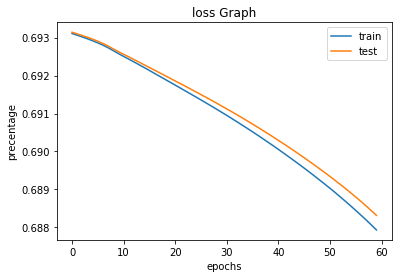

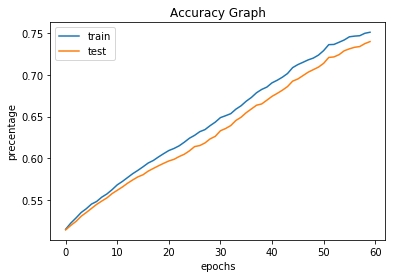

In [13]:
# Verifying the results
print("Ground truths of first 10 images in test set",np.array(y_test[0:10]))
print("Predicted values of first 10 image in test set",y_pred[0:10].ravel())

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.plot(loss,label='train')
plt.plot(val_loss,label='test')
plt.title('loss Graph')
plt.ylabel('precentage')
plt.xlabel('epochs')
plt.legend()
plt.show()

acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
plt.plot(acc,label='train')
plt.plot(val_acc,label='test')
plt.title('Accuracy Graph')
plt.ylabel('precentage')
plt.xlabel('epochs')
plt.legend()
plt.show()

# Visulizing the results
checking the results by visulizing them and creating a confusion matrix. The values of precession and accuracy can be obtained by the help of confusion matrix and f1 scores to compare this architecure with other architectures of neural networks

Predicted     0     1
Actual               
0          9231  3269
1          3238  9262


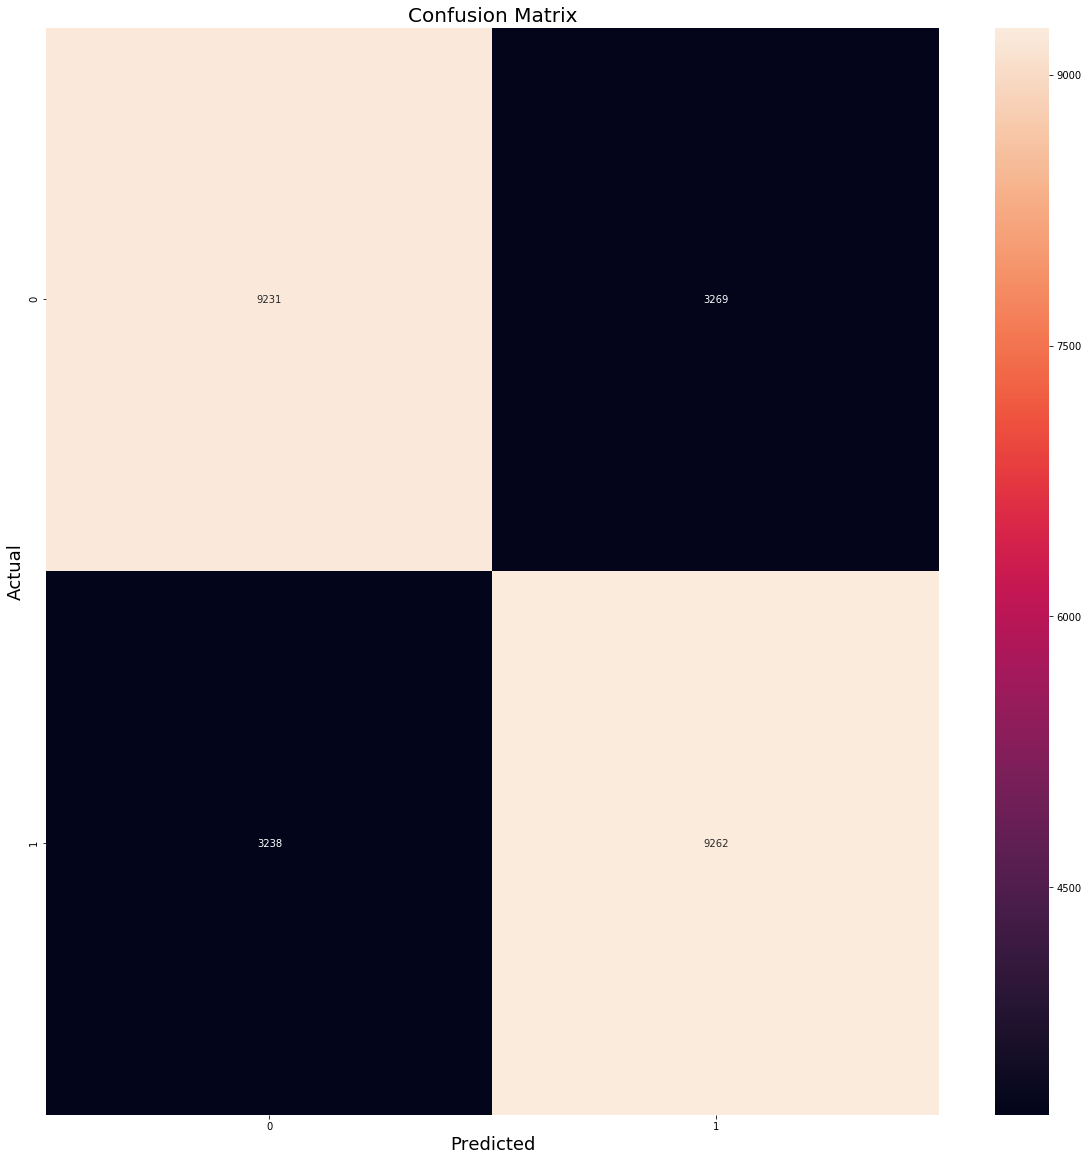

In [14]:
# Visulizing the results
y_pred = y_pred.ravel()
y_pred = pd.Series(y_pred, name='Predicted')
y_test = pd.Series(y_test, name='Actual')
df_confusion  = pd.crosstab(y_test,y_pred, rownames=['Actual'], colnames=['Predicted'])
print(df_confusion)
plt.figure(figsize = (20,20))
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.title('Confusion Matrix',fontsize=20)
sns.heatmap(df_confusion, annot=True,fmt="d")